In [1]:
import tensorflow as tf
import keras
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_generation import gen_data
# from pyod.utils import pairwise_distances_no_broadcast
# from dense_autoencoder import DENSE_Model
from lstm_autoencoder import LSTM_Model_Base
from class_simulationhelper import SimulationHelpers
from lstm_autoencoder import DataGeneration
from lstm_autoencoder import reconstruction
from model_exec import lstm_run, temporalize, reconstruction, get_outliers

# Prepare Dataset

In [3]:
featured_credit = pd.read_csv(r'data\featured_credit.csv', index_col="trans_date")
credit = featured_credit.loc[:,[col for col in featured_credit.columns if "_" not in col]]
d1 = featured_credit.loc[:,[col for col in featured_credit.columns if col.endswith("_d1")]]

# Select n companies with no zero observations and highest variances. 
credit_nozero = credit.loc[:,credit.apply(lambda x : (x==0).sum() == 0)]
# np.random.seed(42)
# n_companies = 6
np.random.seed(25)

n_companies = 8
companies = np.random.choice(credit_nozero.apply(lambda x: (x - x.mean())/x.std()).columns, n_companies, replace=False).tolist()
np.random.seed(None)

def standard_scale(x: pd.Series):
    return (x - x.mean())/x.std()

def has_substr_in_list(s:str, l:list):
    return not all(x not in s for x in l)

features = featured_credit.loc[:,[col for col in featured_credit if ("_" in col) and (has_substr_in_list(col, companies))]]
features = features.apply(standard_scale)
features.shape


(2503, 32)

# Run LSTM

In [7]:
seq_size = 5
n_feature = features.shape[1]

data = features.values
test_size = 0.4
partition_size = int(len(data) * (1 - test_size))

data_train = data[0:partition_size]
data_test = data[partition_size:]

data_train_seq = temporalize(data_train, seq_size)
data_test_seq = temporalize(data_test, seq_size)

lstm_pred, lstm_outliers, history = lstm_run(
    LSTM_Model_Base(
        seq_size, 
        n_feature, 
        [   128,
            32,
            32,
            128
        ], 
        mid_activation=tf.nn.tanh
    ),
    data_train_seq,
    data_test_seq,
    batch_size=512,
    epoch=300,
    metric="bb",
    early_stopping=False,
    cross_feature_check=False
)
# dense_pred, dense_outliers = dense_run(data_train, data_test, n_feature, batch_size = 100)

print(f"Data test shape {data_test.shape}")
print(f"lstm_pred shape {lstm_pred.shape}")
# print(f"dense_pred shape {dense_pred.shape}")

Epoch 1/300
3/3 [==============================] - 5s 56ms/step - loss: 1.0156
Epoch 2/300
3/3 [==============================] - 0s 68ms/step - loss: 1.0150
Epoch 3/300
3/3 [==============================] - 0s 59ms/step - loss: 1.0141
Epoch 4/300
3/3 [==============================] - 0s 57ms/step - loss: 1.0129
Epoch 5/300
3/3 [==============================] - 0s 63ms/step - loss: 1.0110
Epoch 6/300
3/3 [==============================] - 0s 66ms/step - loss: 1.0083
Epoch 7/300
3/3 [==============================] - 0s 60ms/step - loss: 1.0042
Epoch 8/300
3/3 [==============================] - 0s 63ms/step - loss: 0.9994
Epoch 9/300
3/3 [==============================] - 0s 61ms/step - loss: 0.9942
Epoch 10/300
3/3 [==============================] - 0s 57ms/step - loss: 0.9894
Epoch 11/300
3/3 [==============================] - 0s 56ms/step - loss: 0.9846
Epoch 12/300
3/3 [==============================] - 0s 56ms/step - loss: 0.9790
Epoch 13/300
3/3 [==============================]

INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


32/32 [==============================] - 1s 4ms/step
Data test shape (1002, 24)
lstm_pred shape (1002, 24)


c:\Users\linru\Dropbox\Columbia\2022_fall\deep_learning\Research\code\deep-learning-wellington-od\model_exec.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(indices)


In [5]:
lstm_outliers.shape

(24,)

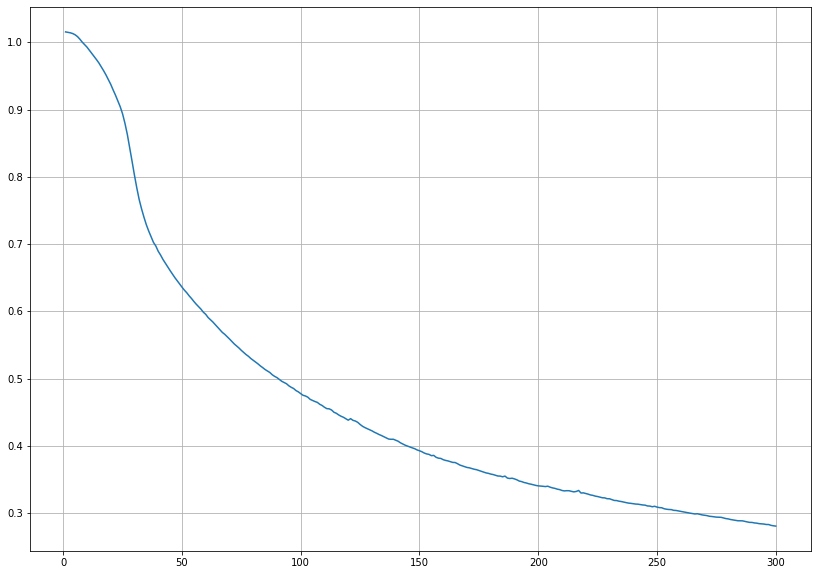

In [14]:
import matplotlib.pyplot as plt

loss = history.history["loss"]
fig, ax = plt.subplots(1, 1, figsize = [14, 10])
ax.plot(np.arange(1, 301), loss)
ax.grid()

# Plotting

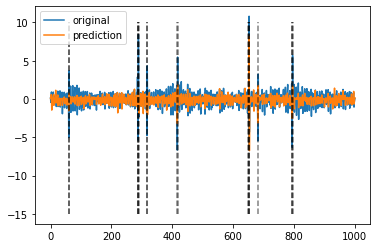

In [6]:
plt.plot(range(1002), data_test[:,3], label = "original")
plt.plot(range(1002), lstm_pred[:,3], label = "prediction")

outliers = lstm_outliers[3]


for o in outliers:
    plt.plot([o]*100, np.linspace(-15,10,100), 'k--', alpha = 0.5)

plt.legend()
plt.show()

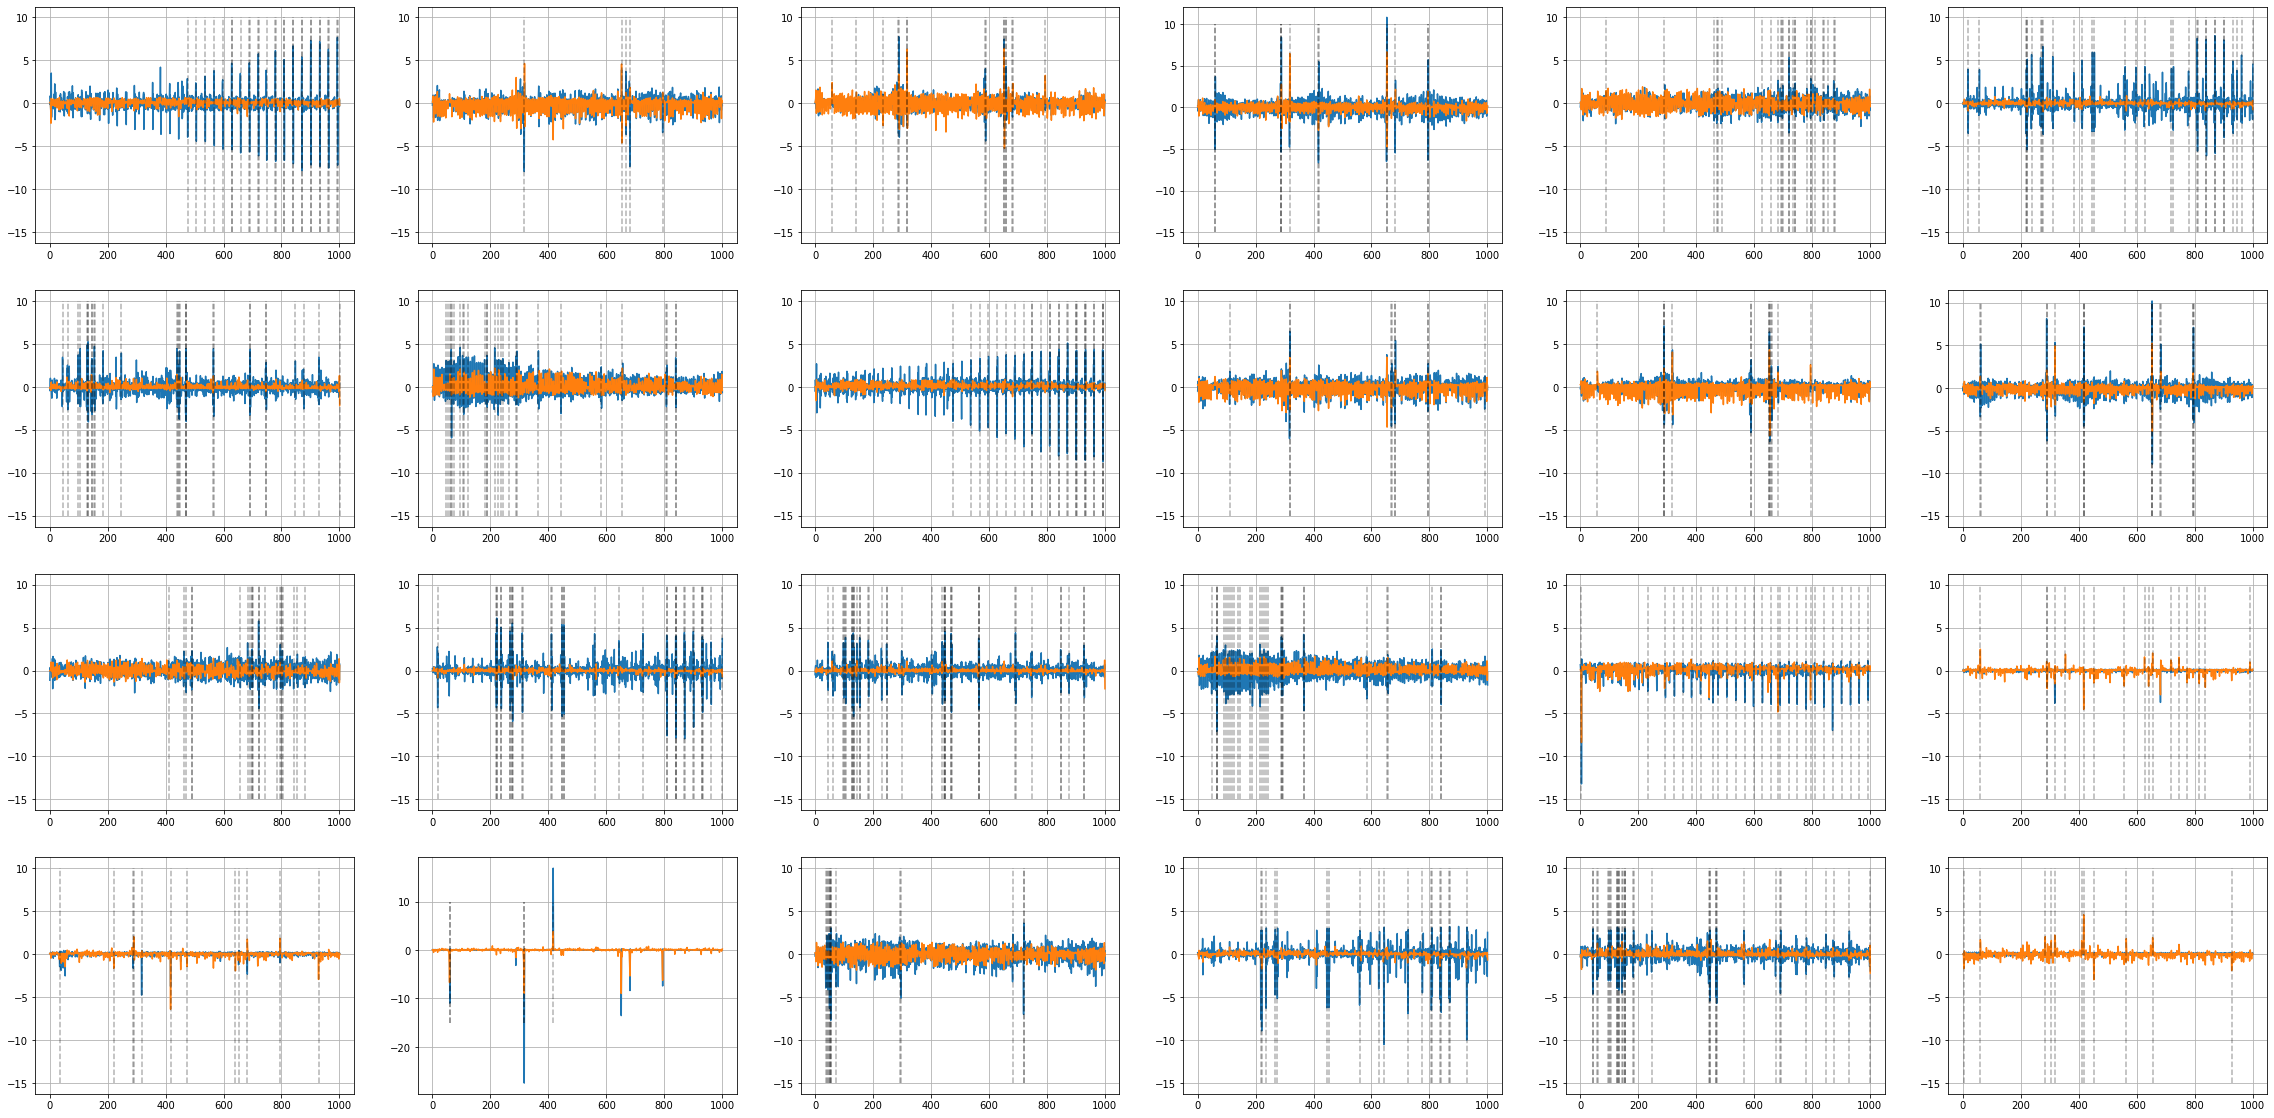

In [12]:
figure, ax = plt.subplots(4, 6, figsize=(40, 20))

for i in range(24):
    ax[i//6][i % 6].plot(range(1002), data_test[:,i], label = "original")
    ax[i//6][i % 6].plot(range(1002), lstm_pred[:,i], label = "prediction")
    ax[i//6][i % 6].grid()
    for o in lstm_outliers[i]:
        ax[i//6][i % 6].plot([o]*100, np.linspace(-15,10,100), 'k--', alpha = 0.3)